# TikTok Viral Predictor (Pre-upload Metadata)

This notebook trains a machine learning model to predict whether a TikTok video will become viral **before it is posted**. 
I will rely only on features that a creator knows at upload time (such as category, video length, hashtags count, sound used, upload hour, followers, following, likes and region), and i exclude post-performance metrics like views, likes, comments, shares and engagement rate.

The dataset `tiktok_video_performance_v2.csv` contains synthetic but realistic TikTok data with a binary `Viral` label. 
The goal is to predict this label based on pre-upload metadata.


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
# Load dataset
DATA_FILE = 'tiktok_video_performance_v2.csv'  
df = pd.read_csv(DATA_FILE)
print(df.head())
print('\nDataset shape:', df.shape)

   Video_ID      Video_Title Category  Region Sound_Used  Followers  \
0         1  Gaming video #0   Gaming   LATAM   Original      17428   
1         2  Comedy video #1   Comedy      US   Trending       1615   
2         3  Comedy video #2   Comedy  Europe   Trending       6967   
3         4  Sports video #3   Sports      US   Trending      17510   
4         5  Gaming video #4   Gaming   LATAM   Original      48316   

   Following  Views  Likes  Comments  Shares  Duration  Hashtags_Count  \
0        117  42090   2165       211     151        97               3   
1        383   3747    283        17      18        68               3   
2        216  44001   3138       115     191       141               2   
3        219  41757   2179       193     102        11               4   
4       2113  45624   4219       208     159        91               5   

                               Hashtags  Upload_Hour Upload_Day  \
0                #beauty #viral #tiktok           10     Frid

In [8]:
# Drop post-performance columns 
drop_cols = ['Views', 'Likes', 'Comments', 'Shares', 'Engagement_Rate']
df = df.drop(columns=[col for col in drop_cols if col in df.columns], errors='ignore')

# Define target and feature columns
target_col = 'Viral'
# Choose metadata feature columns available in the dataset
feature_cols = []
possible_features = ['Category', 'Video_Length', 'Duration', 'Hashtags_Count', 'Sound_Used', 'Upload_Hour',
                     'User_Followers', 'Followers', 'User_Following', 'Following', 'User_Likes', 'Likes_given', 
                     'Region', 'Category_TrendScore']
for col in possible_features:
    if col in df.columns and col != target_col:
        feature_cols.append(col)

print('Using feature columns:', feature_cols)
# Split features and target
X = df[feature_cols]
y = df[target_col]

print('\nTarget value counts:')
print(y.value_counts())

Using feature columns: ['Category', 'Duration', 'Hashtags_Count', 'Sound_Used', 'Upload_Hour', 'Followers', 'Following', 'Region', 'Category_TrendScore']

Target value counts:
Viral
1    6876
0    3124
Name: count, dtype: int64


              precision    recall  f1-score   support

           0       0.25      0.03      0.05       639
           1       0.68      0.96      0.80      1361

    accuracy                           0.66      2000
   macro avg       0.46      0.49      0.42      2000
weighted avg       0.54      0.66      0.56      2000



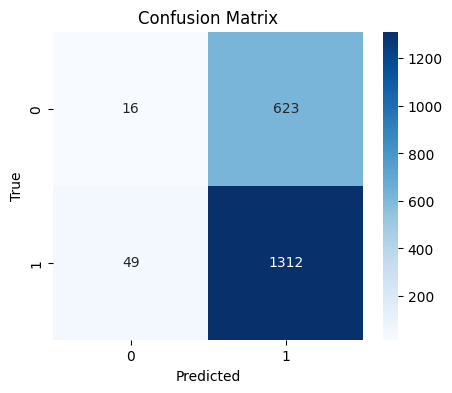

/var/folders/w7/4hl1nvkj2zb6l0_91zpx5jdw0000gn/T/ipykernel_73258/4026653230.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df.head(15), palette='crest')


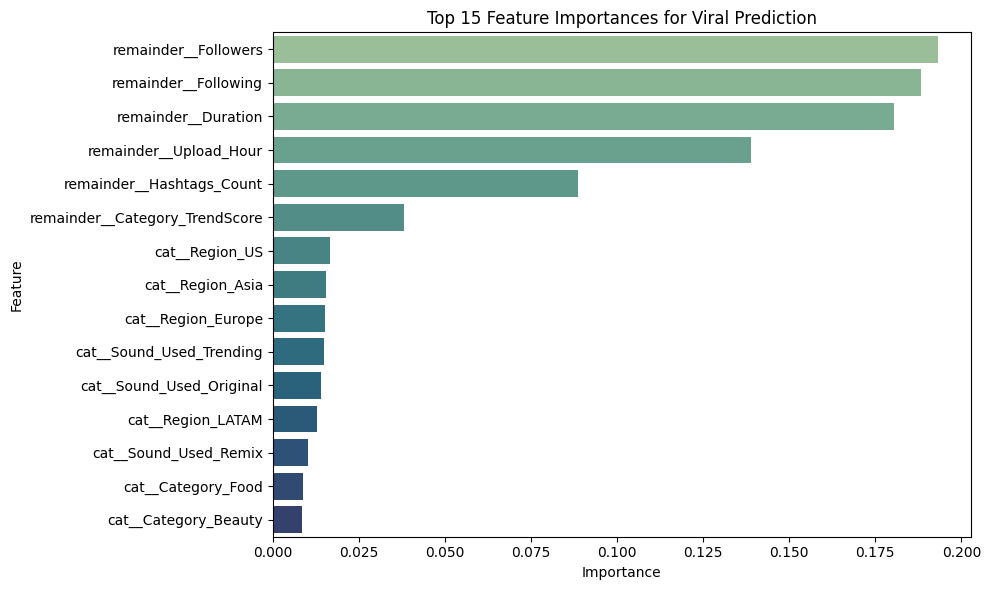

In [6]:
# Identify categorical and numeric columns
categorical_cols = [col for col in feature_cols if X[col].dtype == object]
numeric_cols = [col for col in feature_cols if X[col].dtype != object]

# Preprocess: One-hot encode categorical features, pass through numeric features unchanged
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'
)

# Create the model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=200, random_state=42))
])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model.fit(X_train, y_train)
import joblib
joblib.dump(model, "tiktok_viral_predictor.pkl")


# Predictions
y_pred = model.predict(X_test)

# Evaluation
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Feature importances
try:
    # Get feature names from preprocessor
    feature_names = model.named_steps['preprocessor'].get_feature_names_out()
except AttributeError:
    # For newer sklearn versions:
    feature_names = model.named_steps['preprocessor'].get_feature_names_out()

importances = model.named_steps['classifier'].feature_importances_
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot top 15 important features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(15), palette='crest')
plt.title('Top 15 Feature Importances for Viral Prediction')
plt.tight_layout()
plt.show()

In [5]:
# Function to predict virality for a new video based on pre-upload metadata
def predict_viral(category, video_length, hashtags_count, sound_used, upload_hour, followers, following, likes_given, region, category_trendscore=None):
    '''
    Predict whether a new video will go viral based on metadata.
    Parameters:
        category (str): video category
        video_length (float/int): length of video in seconds
        hashtags_count (int): number of hashtags
        sound_used (str): type of sound used (e.g. 'Original', 'Trending', etc.)
        upload_hour (int): hour of day video is uploaded (0-23)
        followers (int): number of followers of the creator
        following (int): number of accounts the creator follows
        likes_given (int): total likes given by the creator (if available)
        region (str): posting region (e.g. 'US', 'Europe', etc.)
        category_trendscore (float): numeric trend score for the category (optional)
    Returns:
        None (prints prediction and probability)
    '''
    # Build input dictionary using only the selected feature columns
    data = {}
    for col in feature_cols:
        if col == 'Category':
            data[col] = [category]
        elif col in ['Video_Length', 'Duration']:
            data[col] = [video_length]
        elif col == 'Hashtags_Count':
            data[col] = [hashtags_count]
        elif col == 'Sound_Used':
            data[col] = [sound_used]
        elif col == 'Upload_Hour':
            data[col] = [upload_hour]
        elif col in ['User_Followers', 'Followers']:
            data[col] = [followers]
        elif col in ['User_Following', 'Following']:
            data[col] = [following]
        elif col == 'User_Likes':
            data[col] = [likes_given]
        elif col == 'Region':
            data[col] = [region]
        elif col == 'Category_TrendScore':
            data[col] = [category_trendscore if category_trendscore is not None else 0]
        else:
            # For unspecified features just fill with None or 0
            data[col] = [0]

    input_df = pd.DataFrame(data)

    # Predict probability
    probability = model.predict_proba(input_df)[0][1]
    prediction = model.predict(input_df)[0]

    print(f'Prediction: {"Viral" if prediction == 1 else "Not Viral"} (Probability: {probability*100:.2f}%)')

# Example usage:
# predict_viral('Comedy', 30, 3, 'Trending', 18, 100000, 500, 5000, 'US', 0.8)